# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

Populating the interactive namespace from numpy and matplotlib


This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
os.chdir(os.getenv("PUIDATA"))
os.getcwd()

'/nfshome/ku373/PUIdata'

In [3]:
import urllib
urllib.request.urlretrieve("https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy", "MTA_Fare.npy")

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7fba19797390>)

In [4]:
mta = np.load('MTA_Fare.npy')

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [7]:
mta = np.where(mta < 0, nan, mta)

In [8]:
x = range(0,194)
mtalog = np.log10(mta)

/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


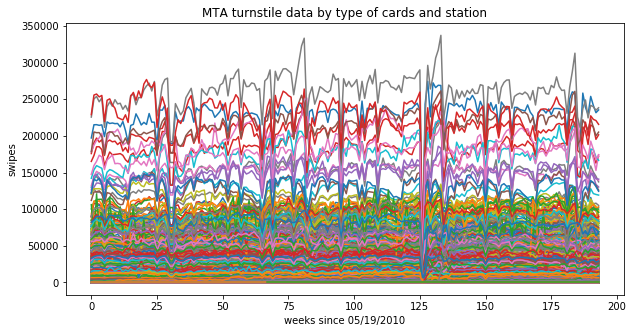

In [9]:
rangem = range(0,600)
rangei = range(0,23)

plt.figure(figsize=(10,5))
plt.title('MTA turnstile data by type of cards and station')
plt.xlabel('weeks since 05/19/2010')
plt.ylabel('swipes')

for m in rangem:
    for i in rangei:
        y = mta[m][i]
        plt.plot(x,y) 

#### Figure 1: time series for all ride types and all stations. As this is messy, we should populate a graph in a logscale first.

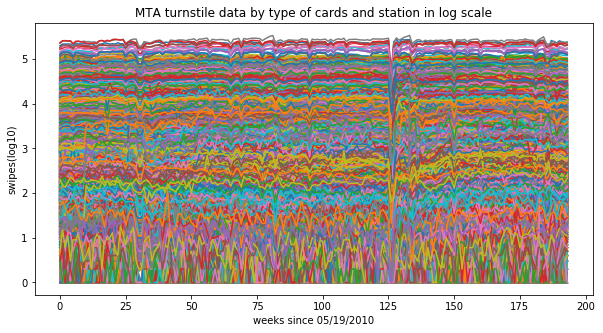

In [10]:
rangem = range(0,600)
rangei = range(0,23)

plt.figure(figsize=(10,5))
plt.title('MTA turnstile data by type of cards and station in log scale')
plt.xlabel('weeks since 05/19/2010')
plt.ylabel('swipes(log10)')

for m in rangem:
    for i in rangei:
        y = mtalog[m][i]
        plt.plot(x,y)        

#### Figure 2: time series for all ride types and all stations in semi-log space. As this is still messy, we should populate a graph in a diffrent way for analysis.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [11]:
# First, I sum up swipe counts for all staions by date.
mtatran = mta.transpose(2,0,1)
mtatran.shape

(194, 600, 23)

In [12]:
mtatranlist = []
for i in range(0,194):
    x = mtatran[i]
    x = np.nansum(x)
    mtatranlist.append(x)

In [13]:
thresholds = [np.nanmean(mtatranlist) + 3 * np.nanstd(mtatranlist), 
              np.nanmean(mtatranlist) - 3 * np.nanstd(mtatranlist)]
thresholds

[38733231.13623668, 20829468.606031362]

In [14]:
judge = (mtatranlist > thresholds[0]) | (mtatranlist < thresholds[1])
type(judge)

numpy.ndarray

In [15]:
for i in range(0, len(judge)):
    if judge[i] == True:
        print(i)

126


In [16]:
week = pd.date_range(start='5/19/2010',periods=194, freq='7D')
week[126]

Timestamp('2012-10-17 00:00:00', freq='7D')

In [17]:
week[193]
#194 weeks from 05/19/2010 to 02/19/2014

Timestamp('2014-01-29 00:00:00', freq='7D')

## My analysis

## I set 3 sigma from meand as a thresholds, and the ridership data aggregated by date has a day when the ridership is below the threshold. Right after week 126, 10/25, Hurricane Sandy came to NY. This turnstile data implies that the hurricane seriously affects ridership of MTA. 

## The date the proffessor gave us might be wrong. The instruction said date range is "194 weeks from 05/19/2010 to 02/19/2014 ", but our calculation told we have more dates/weeks. Also, the original figure 2 in the instruction said " start from 5/21/2010 ", which is inconsistant with the date above. This might be the reason why week 126 is not just around the date Sandy coming.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [20]:
mtatrantype = mta.transpose(1,2,0)
mtatrantype.shape

(23, 194, 600)

In [21]:
a = np.zeros((23,194))

for i in range(0,23):
    for m in range(0,194):
        f = mtatrantype[i][m]
        x = np.nansum(f)
        a[i][m] = x

In [22]:
mtatype = pd.DataFrame(a, index=ridetype).T

In [23]:
mtatypesmooth = mtatype.rolling(window=10, min_periods=5).mean()

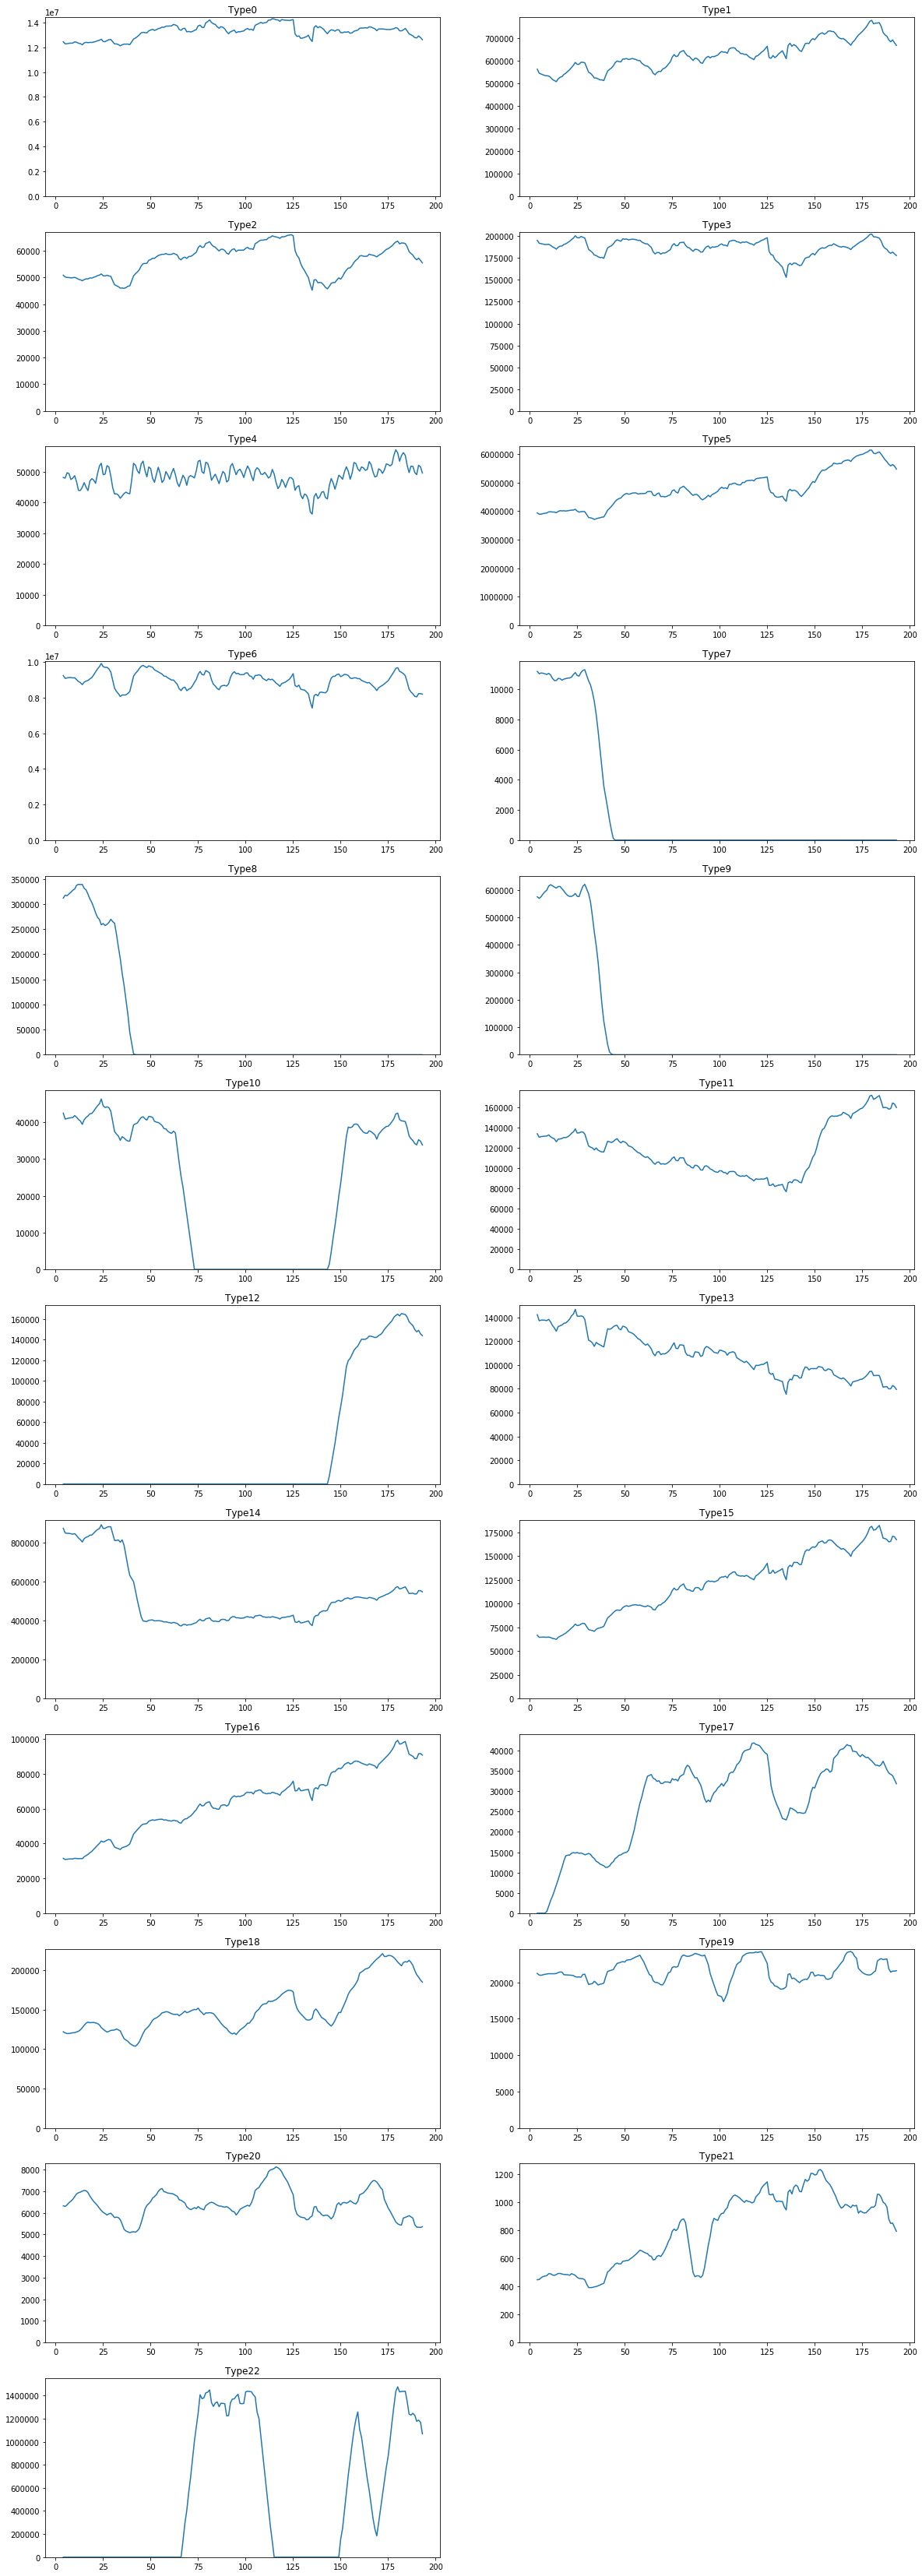

In [24]:
x = range(0,194)

plt.figure(figsize = (20,60))
for i in range(0,23):
    y = mtatypesmooth.iloc[:,i]
    plt.subplot(12,2,i+1)
    plt.plot(x,y)
    plt.ylim(0,)
    plt.title('Type'+str(i))

Figure 3: The 23 graphs show riderships by card types. They imply that type16 and type15 show sharp increase during the period. On the other hand, type 7,8,9 might be abolished and not be used now, showing sharp drop. 

In [25]:
# Eliminating outliers and check the most increased and decreased type.
plt.figure(figsize = (20,60))
for i in range(0,23):
    y = mtatypesmooth.iloc[:,i]
    if y[5:10].sum() >1000 : print('type'+ str(i), y[-5:].sum()/y[5:10].sum())

type0 1.0371926280346364
type1 1.269126148402213
type2 1.1324505667437792
type3 0.9437878826460451
type4 1.0400213277616241
type5 1.4260638963393346
type6 0.8947381714840865
type7 0.00021200499343520827
type8 1.0900429243306842e-05
type9 1.5739795514181744e-06
type10 0.8366385475539485
type11 1.2262206170532726
type13 0.5874139276672591
type14 0.6446674445291941
type15 2.595939157903392
type16 2.9069977263373086
type18 1.5942758583906365
type19 1.0256001110819715
type20 0.8301780487871379
type21 1.7989139505912477


<Figure size 1440x4320 with 0 Axes>

## Type 16 grows the most. It has almost tripled. 
## Type 9 experienced the sharpest drop. It goes alomost zero. That might mean the card type is abolished.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [26]:
mtat = mta.transpose(1,0,2)

In [27]:
dfmtaori = pd.DataFrame(mtat[0])
for i in range(1,23):
    dfmta = pd.DataFrame(mtat[i])
    dfmtaori = pd.concat([dfmtaori,dfmta])
dfmtaori = dfmtaori.reset_index(drop=None)

In [28]:
ylabel = []
for i in range (23):
    a = [i] * 600
    ylabel += a
    

In [29]:
dfmtaori['ylabel'] = ylabel
dfmtaori['stationid']=dfmtaori['index']

In [30]:
dfmtaori.loc[0,list(range(1, 194))].mean()

58595.397905759164

In [31]:
dfmtaori[list(range(1,194))].mean(axis=1).head()

/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


0    58595.397906
1    16743.418182
2     3550.248705
3     8757.036269
4     9686.958549
dtype: float64

## Get mean and std

In [32]:
dfmtaori['mean'] = [0] * len(dfmtaori.index)
dfmtaori['std'] = [0] * len(dfmtaori.index)


In [33]:
for i in range(13800):
    dfmtaori.loc[i, ['mean']] = dfmtaori.loc[i,list(range(1, 194))].mean()
for i in range(13800):
    dfmtaori.loc[i, ['std']] = dfmtaori.loc[i,list(range(1, 194))].std()

In [34]:
dfmtaori.head()

,index,0,1,2,3,4,5,6,7,8,...,188,189,190,191,192,193,ylabel,stationid,mean,std
0,0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,...,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,0,0,58595.397906,17853.935084
1,1,16210.0,20179.0,21769.0,19307.0,18076.0,15541.0,18092.0,17689.0,17846.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,16743.418182,3159.466171
2,2,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,...,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,0,2,3550.248705,392.994275
3,3,7774.0,8158.0,8405.0,6839.0,8581.0,6572.0,7207.0,7304.0,7073.0,...,8788.0,8000.0,8662.0,9247.0,8792.0,8519.0,0,3,8757.036269,936.579050
4,4,8794.0,9388.0,9437.0,7799.0,9836.0,7259.0,7994.0,7876.0,7855.0,...,9972.0,8972.0,9828.0,10547.0,10191.0,10056.0,0,4,9686.958549,990.933440


## Drop nan

In [35]:
dfmtaorina = dfmtaori.dropna(axis = 0, how = 'any')

In [36]:
dfmtaorina.head()

,index,0,1,2,3,4,5,6,7,8,...,188,189,190,191,192,193,ylabel,stationid,mean,std
2,2,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,...,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0,0,2,3550.248705,392.994275
3,3,7774.0,8158.0,8405.0,6839.0,8581.0,6572.0,7207.0,7304.0,7073.0,...,8788.0,8000.0,8662.0,9247.0,8792.0,8519.0,0,3,8757.036269,936.579050
4,4,8794.0,9388.0,9437.0,7799.0,9836.0,7259.0,7994.0,7876.0,7855.0,...,9972.0,8972.0,9828.0,10547.0,10191.0,10056.0,0,4,9686.958549,990.933440
5,5,8509.0,9095.0,9256.0,7723.0,9571.0,7256.0,7914.0,7757.0,7819.0,...,9614.0,8945.0,9529.0,10331.0,9882.0,9390.0,0,5,9608.823834,1021.403049
6,6,6012.0,6637.0,6633.0,5648.0,6936.0,5064.0,5719.0,5594.0,5563.0,...,6874.0,6412.0,6959.0,7185.0,6860.0,6717.0,0,6,6839.906736,697.390845


you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [ ]:

    the time series mean divided by the mean of all time series for that station
    the time series standard deviation by the standard deviation of all time series for that station
    the slope and intercept of a line fit to the standardized time series

      (time_series - time_series.mean())/time_series.std()



In [ ]:
'''normed_time_series_mean = ...
normed_time_series_std = ...'''

In [ ]:
'''standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")'''

In [ ]:
'''allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]'''

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [ ]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [ ]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

In [ ]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [ ]:
clf = rfc()...

and use sklearn confusion_matrix to see the errors

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [ ]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=ridetype))